In [2]:
import os
import sys
import shutil
import glob
import random
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
import dask.bag as db
import dask.dataframe as dd
import dask
import json

from astropy.table import Table
from functools import partial
from dask.distributed import Client, progress
from dask.delayed import delayed
from sklearn.neighbors import KDTree

In [3]:
def gnomonic(lon, lat, clon, clat):

    phi  = np.radians(lat)
    l    = np.radians(lon)
    phi1 = np.radians(clat)
    l0   = np.radians(clon)

    cosc = np.sin(phi1)*np.sin(phi) + np.cos(phi1)*np.cos(phi)*np.cos(l-l0)
    x = np.cos(phi)*np.sin(l-l0) / cosc
    y = (np.cos(phi1)*np.sin(phi) - np.sin(phi1)*np.cos(phi)*np.cos(l-l0)) / cosc

    return (np.degrees(x), np.degrees(y))


def gc_dist(lon1, lat1, lon2, lat2):

    lon1 = np.radians(lon1); lat1 = np.radians(lat1)
    lon2 = np.radians(lon2); lat2 = np.radians(lat2)

    return np.degrees(2*np.arcsin(np.sqrt( (np.sin((lat1-lat2)*0.5))**2 + np.cos(lat1)*np.cos(lat2)*(np.sin((lon1-lon2)*0.5))**2 )))


In [22]:
def read_xmparquet(fn):
    return dd.read_parquet(fn)

def xm_task(df, md, clon, clat, tree, xy2, id2, ra2, dec2, n_neighbors, dthresh):
    ret ={}
    ra1 = df[md['ra_kw']]
    dec1 = df[md['dec_kw']]
    id1 = df[md['id_kw']]
    xy1 = np.column_stack(gnomonic(ra1, dec1, clon, clat))
    dists, inds = tree.query(xy1, k=min(n_neighbors, len(xy2))) 

    c1matches = []
    for k,match_idx in enumerate(inds[0]):
        match = {}
        match['_M1'] = id1
        match['_M2'] = id2[match_idx]
        match['_DIST'] = gc_dist(ra1, dec1, ra2[match_idx], dec2[match_idx])
        match['_LON'] = ra2[match_idx]
        match['_LAT'] = dec2[match_idx]
        match['_NR'] = k
        c1matches.append(match)

    c1matches = [c1m for c1m in c1matches if c1m['_DIST'] <= dthresh]
    if c1matches:
        ret[id1] = c1matches
        return ret
    return {}


def dask_xm(match_cats, c1_md, c2_md, n_neighbors=1, dthresh=4.0):
    '''
    documentation
    '''

    c1 = match_cats[0]
    c2 = match_cats[1]

    c1_df = read_xmparquet(c1).reset_index()
    c2_df = read_xmparquet(c2).reset_index()

    c1_order = int(c1.split('Norder')[1].split('/')[0])
    c1_pix = int(c1.split('Npix')[1].split('/')[0])
    c2_order = int(c2.split('Norder')[1].split('/')[0])
    c2_pix = int(c2.split('Npix')[1].split('/')[0])

    if c1_order > c2_order:
        order, pix = c1_order, c1_pix
        #cull the c2 sources
        c2_df['hips_pix'] = hp.ang2pix(2**order, 
            c2_df[c2_md['ra_kw']].values, 
            c2_df[c2_md['dec_kw']].values, 
            lonlat=True, nest=True
        )
        c2_df = c2_df.loc[c2_df['hips_pix'] == pix]
        
    else:
        order, pix = c2_order, c2_pix
        #cull the c1 sources
        c1_df['hips_pix'] = hp.ang2pix(2**order, 
            c1_df[c1_md['ra_kw']].values, 
            c1_df[c1_md['dec_kw']].values, 
            lonlat=True, nest=True
        )
        c1_df = c1_df.loc[c1_df['hips_pix'].isin([pix])]

    (clon, clat) = hp.pix2ang(hp.order2nside(order), pix, nest=True, lonlat=True)

    #get id, ra, and dec columns
    id2 = c2_df[c2_md['id_kw']]
    ra2 = c2_df[c2_md['ra_kw']]
    dec2 = c2_df[c2_md['dec_kw']]
    #print('id2', type(id2), id2.iloc[0])
    xy2 = np.column_stack(gnomonic(ra2, dec2, clon, clat))
    #print(c2, clon, clat, order, pix)
    tree = KDTree(xy2, leaf_size=2)

    matches = []
    args = (c1_md, clon, clat, tree, xy2, id2, ra2, dec2, n_neighbors, dthresh)
    ret = c1_df.map_partitions(
        xm_task,
        c1_md, clon, clat, tree, xy2, id2, ra2, dec2, n_neighbors, dthresh,
    )
    if ret:
        matches.append(ret)
    return len(matches)
    #return 1

In [ ]:
client = Client(local_directory='/epyc/projects3/sam_hipscat/', n_workers=4, threads_per_worker=1)

test_data = [
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5544/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5545/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5546/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5547/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder4/Npix396/catalog.parquet',  '/epyc/projects3/sam_hipscat/output/gaia_real/Norder3/Npix99/catalog.parquet']
]
with open('/epyc/projects3/sam_hipscat/output/sdss_real/sdss_real_meta.json') as f:
    c1_md = json.load(f)
with open('/epyc/projects3/sam_hipscat/output/gaia_real/gaia_real_meta.json') as f:
    c2_md = json.load(f)

results = []
for td in test_data:
    f = dask_xm(td, c1_md, c2_md)
    results.append(f)

total = sum(results)
#total.visualize()
result = total.compute()
print(result)

client.close()
#df = pd.read_parquet(test_data[0][0])[:10]
#df_dd = dd.from_pandas(df, npartitions=3)
#df_dd.apply(test_function, axis=1)

In [ ]:
@dask.delayed
def read_xmparquet(fn):
    return dd.read_parquet(fn)

def gminusr(d):
    return d['gCalib']-d['rCalib']
    #d.assign(gminusr=lambda x: x.gCalib-x.rCalib)

class dask_class():

    def __init__(self, files, meta_fn):
        self.files=files
        self.meta_fn=meta_fn
        self.frames = []
        self.results = []
        self._load_meta()
        self._load_files()

    def _load_meta(self):
        with open(self.meta_fn) as f:
            self.meta = json.load(f)

    def _load_files(self):
        for f in self.files[:1]:
            self.frames.append(read_xmparquet(f[0]))

    def delayed_process1(self):
        #manipulate_files
        print('manipulating')
        for i,f in enumerate(self.frames):
            #f.assign(gminusr=lambda x: x.gCalib-x.rCalib)
            self.results.append(f.map_partitions(gminusr))
        return self

    def delayed_process2(self):
        t = []
        for f in self.frames():
            self.results.append(sum(f['gminusr']))
        
        return self

    def delayed_process3(self):
        #save_manipulations
        return self

    def execute(self):
        return dask.compute(self.results)

In [ ]:
client = Client(local_directory='/epyc/projects3/sam_hipscat/', n_workers=4, threads_per_worker=1)

test_data = [
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5544/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5545/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5546/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5547/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder4/Npix396/catalog.parquet',  '/epyc/projects3/sam_hipscat/output/gaia_real/Norder3/Npix99/catalog.parquet']
]

metafn = '/epyc/projects3/sam_hipscat/output/sdss_real/sdss_real_meta.json'

t = dask_class(files=test_data, meta_fn=metafn)
f = t.delayed_process1().delayed_process2().execute()
print('this is f')
print(f)
#returns a futures/ .get() or .result()

client.close()

In [37]:
def dask_gnomonic_cull(df, df_md, order, pix, clon, clat, cols=[], tocull=True):
    df = df.copy()
    if tocull:
        df['hips_pix'] = hp.ang2pix(2**order, 
            df[df_md['ra_kw']].values, 
            df[df_md['dec_kw']].values, 
            lonlat=True, nest=True
        )
        df = df.loc[df['hips_pix'].isin([pix])]
    
    #user specifies which columns to return
    if len(cols):
        #ensure user doesn't cull the ra,dec,and id columns
        expected_cols = [
            df_md['ra_kw'],
            df_md['dec_kw'],
            df_md['id_kw']
        ]
        for ec in expected_cols:
            if ec not in cols:
                cols.append(ec)
        df = df[cols]

    phi  = np.radians(df[df_md['dec_kw']].values)
    l    = np.radians(df[df_md['ra_kw']].values)
    phi1 = np.radians(clat)
    l0   = np.radians(clon)

    cosc = np.sin(phi1)*np.sin(phi) + np.cos(phi1)*np.cos(phi)*np.cos(l-l0)
    x = np.cos(phi)*np.sin(l-l0) / cosc
    y = (np.cos(phi1)*np.sin(phi) - np.sin(phi1)*np.cos(phi)*np.cos(l-l0)) / cosc

    df['x_gnomonic'] = np.degrees(x)
    df['y_gnomonic'] = np.degrees(y)

    return df



def dask_gnomonic(df, df_md, clon, clat):

    phi  = np.radians(df[df_md['dec_kw']].values)
    l    = np.radians(df[df_md['ra_kw']].values)
    phi1 = np.radians(clat)
    l0   = np.radians(clon)

    cosc = np.sin(phi1)*np.sin(phi) + np.cos(phi1)*np.cos(phi)*np.cos(l-l0)
    x = np.cos(phi)*np.sin(l-l0) / cosc
    y = (np.cos(phi1)*np.sin(phi) - np.sin(phi1)*np.cos(phi)*np.cos(l-l0)) / cosc

    data = {'x':np.degrees(x), 'y':np.degrees(y)}
    return pd.DataFrame(data)


def xy_columnstack(data):
    ret = []
    xs, ys = data['x_gnomonic'].to_list(), data['y_gnomonic'].to_list()
    
    for i,x in enumerate(xs):
        ret.append([xs[i], ys[i]])
    return np.asanyarray(ret)


def dask_xmtask(df, df_md, id2, ra2, dec2, tree, n_neighbors, dthresh):

    _m1 = []
    _m2 = []
    _dist = []
    _lon = []
    _lat = []
    _nr = []

    vals = zip(
        df[df_md['id_kw']], 
        df[df_md['ra_kw']],
        df[df_md['dec_kw']],
        df['x_gnomonic'],
        df['y_gnomonic']
    )

    #forloop over catalog1 dataframe
    for id1, ra1, dec1, xg, yg in vals:
        xy1 = [[xg, yg]]
        dists, inds = tree.query(xy1, k=n_neighbors)
        
        for k,match_idx in enumerate(inds[0]):
            match_dist = gc_dist(ra1, dec1, ra2[match_idx], dec2[match_idx])
            #if match_dist <= dthresh:
            _m1.append(id1)
            _m2.append(id2[match_idx])
            _dist.append(match_dist)
            _lon.append(ra2[match_idx])
            _lat.append(dec2[match_idx])
            _nr.append(k)

    #output = np.empty(len(c1_df)*k)

    data = {
        '_m1'  :   _m1,
        '_m2'  :   _m2,
        '_dist':  _dist,
        '_lon' :  _lon,
        '_lat' :  _lat,
        '_nr'  :  _nr
    }

    return pd.DataFrame(data)
    

In [25]:
order = 5
pix = 5544

n_neighbors = 1
dthresh = 0.01


def xmatcher(match_cats, c1_md, c2_md, n_neighbors=1, dthresh=0.01):
    c1 = '/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5544/catalog.parquet'
    c2 = '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'

    c1_order = int(c1.split('Norder')[1].split('/')[0])
    c1_pix = int(c1.split('Npix')[1].split('/')[0])
    c2_order = int(c2.split('Norder')[1].split('/')[0])
    c2_pix = int(c2.split('Npix')[1].split('/')[0])

    c1_df = dd.read_parquet(c1)
    c2_df = dd.read_parquet(c2)

    #c1_df.is_copy = False
    #c2_df.is_copy = False

    tocull1 = False
    tocull2 = False

    if c2_order > c1_order:
        order, pix = c2_order, c2_pix
        tocull1=True
    else:
        order, pix = c1_order, c1_pix
        tocull2=True

    (clon, clat) = hp.pix2ang(hp.order2nside(order), pix, nest=True, lonlat=True)

    c1_df = c1_df.map_partitions(
        dask_gnomonic_cull,
        df_md=c1_md,
        order=order, pix=pix,
        clon=clon, clat=clat,
        tocull=tocull1
    )

    c2_df = c2_df.map_partitions(
        dask_gnomonic_cull,
        df_md=c2_md,
        order=order, pix=pix,
        clon=clon, clat=clat,
        tocull=tocull2
    ).compute()


    id2 = c2_df[c2_md['id_kw']].to_list()
    ra2 = c2_df[c2_md['ra_kw']].to_list()
    dec2 = c2_df[c2_md['dec_kw']].to_list()

    #xy1 = xy_columnstack(c1_df)
    xy2 = xy_columnstack(c2_df)
    tree = KDTree(xy2, leaf_size=2)

    #dists, inds = tree.query(xy1, k=2)
    #c1_df[0] = ind[0]
    
    #rint(dists[:10], inds[:10])

    matches = c1_df.map_partitions(
        dask_xmtask, 
        df_md=c1_md, 
        id2=id2,
        ra2=ra2,
        dec2=dec2,
        tree=tree, 
        n_neighbors=3, 
        dthresh=0.01, 
    )

    #print(type(matches))

    print(len(matches))
    #print(len(matches))


with open('/epyc/projects3/sam_hipscat/output/sdss_real/sdss_real_meta.json') as f:
    c1_md = json.load(f)
with open('/epyc/projects3/sam_hipscat/output/gaia_real/gaia_real_meta.json') as f:
    c2_md = json.load(f)

c1 = '/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5544/catalog.parquet'
c2 = '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'
matchcats = [[c1, c2]]

xmatcher(matchcats[0], c1_md=c1_md, c2_md=c2_md)

498195


In [58]:
t = [[0,1], [1,2]]
print(min(t[0]), min(t[1]))

0 1


In [16]:
#%%timeit
n_neighbors = 1
dthresh = 0.01


def gc_dist(lon1, lat1, lon2, lat2):

    lon1 = np.radians(lon1); lat1 = np.radians(lat1)
    lon2 = np.radians(lon2); lat2 = np.radians(lat2)

    return np.degrees(2*np.arcsin(np.sqrt( (np.sin((lat1-lat2)*0.5))**2 + np.cos(lat1)*np.cos(lat2)*(np.sin((lon1-lon2)*0.5))**2 )))


def frame_cull(df, df_md, order, pix, cols=[], tocull=True):
    if tocull:
        df['hips_pix'] = hp.ang2pix(2**order, 
            df[df_md['ra_kw']].values, 
            df[df_md['dec_kw']].values, 
            lonlat=True, nest=True
        )
        df = df.loc[df['hips_pix'].isin([pix])]
    
    #user specifies which columns to return
    if len(cols):
        #ensure user doesn't cull the ra,dec,and id columns
        expected_cols = [
            df_md['ra_kw'],
            df_md['dec_kw'],
            df_md['id_kw']
        ]
        for ec in expected_cols:
            if ec not in cols:
                cols.append(ec)
        df = df[cols]

    return df


def frame_gnomonic(df, df_md, clon, clat):

    phi  = np.radians(df[df_md['dec_kw']].values)
    l    = np.radians(df[df_md['ra_kw']].values)
    phi1 = np.radians(clat)
    l0   = np.radians(clon)

    cosc = np.sin(phi1)*np.sin(phi) + np.cos(phi1)*np.cos(phi)*np.cos(l-l0)
    x = np.cos(phi)*np.sin(l-l0) / cosc
    y = (np.cos(phi1)*np.sin(phi) - np.sin(phi1)*np.cos(phi)*np.cos(l-l0)) / cosc

    ret = np.column_stack((np.degrees(x), np.degrees(y)))
    del phi, l, phi1, l0, cosc, x, y
    return ret


def xmatcher2(match_cats, c1_md, c2_md, c1_cols=[], c2_cols=[], n_neighbors=1, dthresh=0.01):
    c1 = match_cats[0]
    c2 = match_cats[1]

    c1_order = int(c1.split('Norder')[1].split('/')[0])
    c1_pix = int(c1.split('Npix')[1].split('/')[0])
    c2_order = int(c2.split('Norder')[1].split('/')[0])
    c2_pix = int(c2.split('Npix')[1].split('/')[0])

    c1_df = pd.read_parquet(c1, engine='pyarrow')
    c2_df = pd.read_parquet(c2, engine='pyarrow')


    tocull1 = False
    tocull2 = False

    if c2_order > c1_order:
        order, pix = c2_order, c2_pix
        tocull1=True
    else:
        order, pix = c1_order, c1_pix
        tocull2=True

    (clon, clat) = hp.pix2ang(hp.order2nside(order), pix, nest=True, lonlat=True)

    c1_df = frame_cull(
        df=c1_df, df_md=c1_md,
        order=order, pix=pix,
        cols=c1_cols,
        tocull=tocull1
    )

    c2_df = frame_cull(
        df=c2_df, df_md=c2_md,
        order=order, pix=pix,
        cols=c2_cols,
        tocull=tocull2
    )

    #ret = 0
    ret = pd.DataFrame()
    if len(c1_df) and len(c2_df):

        xy1 = frame_gnomonic(c1_df, c1_md, clon, clat)
        xy2 = frame_gnomonic(c2_df, c2_md, clon, clat)

        tree = KDTree(xy2, leaf_size=2)
        dists, inds = tree.query(xy1, k=n_neighbors)

        outIdx = np.arange(len(c1_df)*n_neighbors)
        leftIdx = outIdx // n_neighbors
        rightIdx = inds.ravel()
        out = pd.concat(
            [
                c1_df.iloc[leftIdx].reset_index(drop=True),   # select the rows of the left table
                c2_df.iloc[rightIdx].reset_index(drop=True)  # select the rows of the right table
            ], axis=1)  # concat the two tables "horizontally" (i.e., join columns, not append rows)

        out["_DIST"] = gc_dist(
            out[c1_md['ra_kw']], out[c1_md['dec_kw']],
            out[c2_md['ra_kw']], out[c2_md['dec_kw']]
        )

        out = out.loc[out['_DIST'] < dthresh]
        ret = out
        del out, dists, inds, outIdx, leftIdx, rightIdx, xy1, xy2
    del c1_df, c2_df
    return ret
    

def rr_lyrae_filter(df):
    s = np.int64(df['ID']) % 5
    #s = np.random.uniform(0, 1)
    return s
    


In [14]:
client = Client(local_directory='/epyc/projects3/sam_hipscat/', n_workers=4, threads_per_worker=1)
client

distributed.diskutils - INFO - Found stale lock file and directory '/epyc/projects3/sam_hipscat/dask-worker-space/worker-hrqjr1_b', purging
distributed.diskutils - INFO - Found stale lock file and directory '/epyc/projects3/sam_hipscat/dask-worker-space/worker-1wfr7_gz', purging
distributed.diskutils - INFO - Found stale lock file and directory '/epyc/projects3/sam_hipscat/dask-worker-space/worker-kg6shnhg', purging
distributed.diskutils - INFO - Found stale lock file and directory '/epyc/projects3/sam_hipscat/dask-worker-space/worker-6sg91ubu', purging
distributed.diskutils - INFO - Found stale lock file and directory '/epyc/projects3/sam_hipscat/dask-worker-space/worker-dy3wpg6b', purging
distributed.diskutils - INFO - Found stale lock file and directory '/epyc/projects3/sam_hipscat/dask-worker-space/worker-calxpfc0', purging
distributed.diskutils - INFO - Found stale lock file and directory '/epyc/projects3/sam_hipscat/dask-worker-space/worker-9hee7y0b', purging
distributed.diskutil

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39602,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:36217,Total threads: 1
Dashboard: http://127.0.0.1:45252/status,Memory: 251.90 GiB
Nanny: tcp://127.0.0.1:44835,


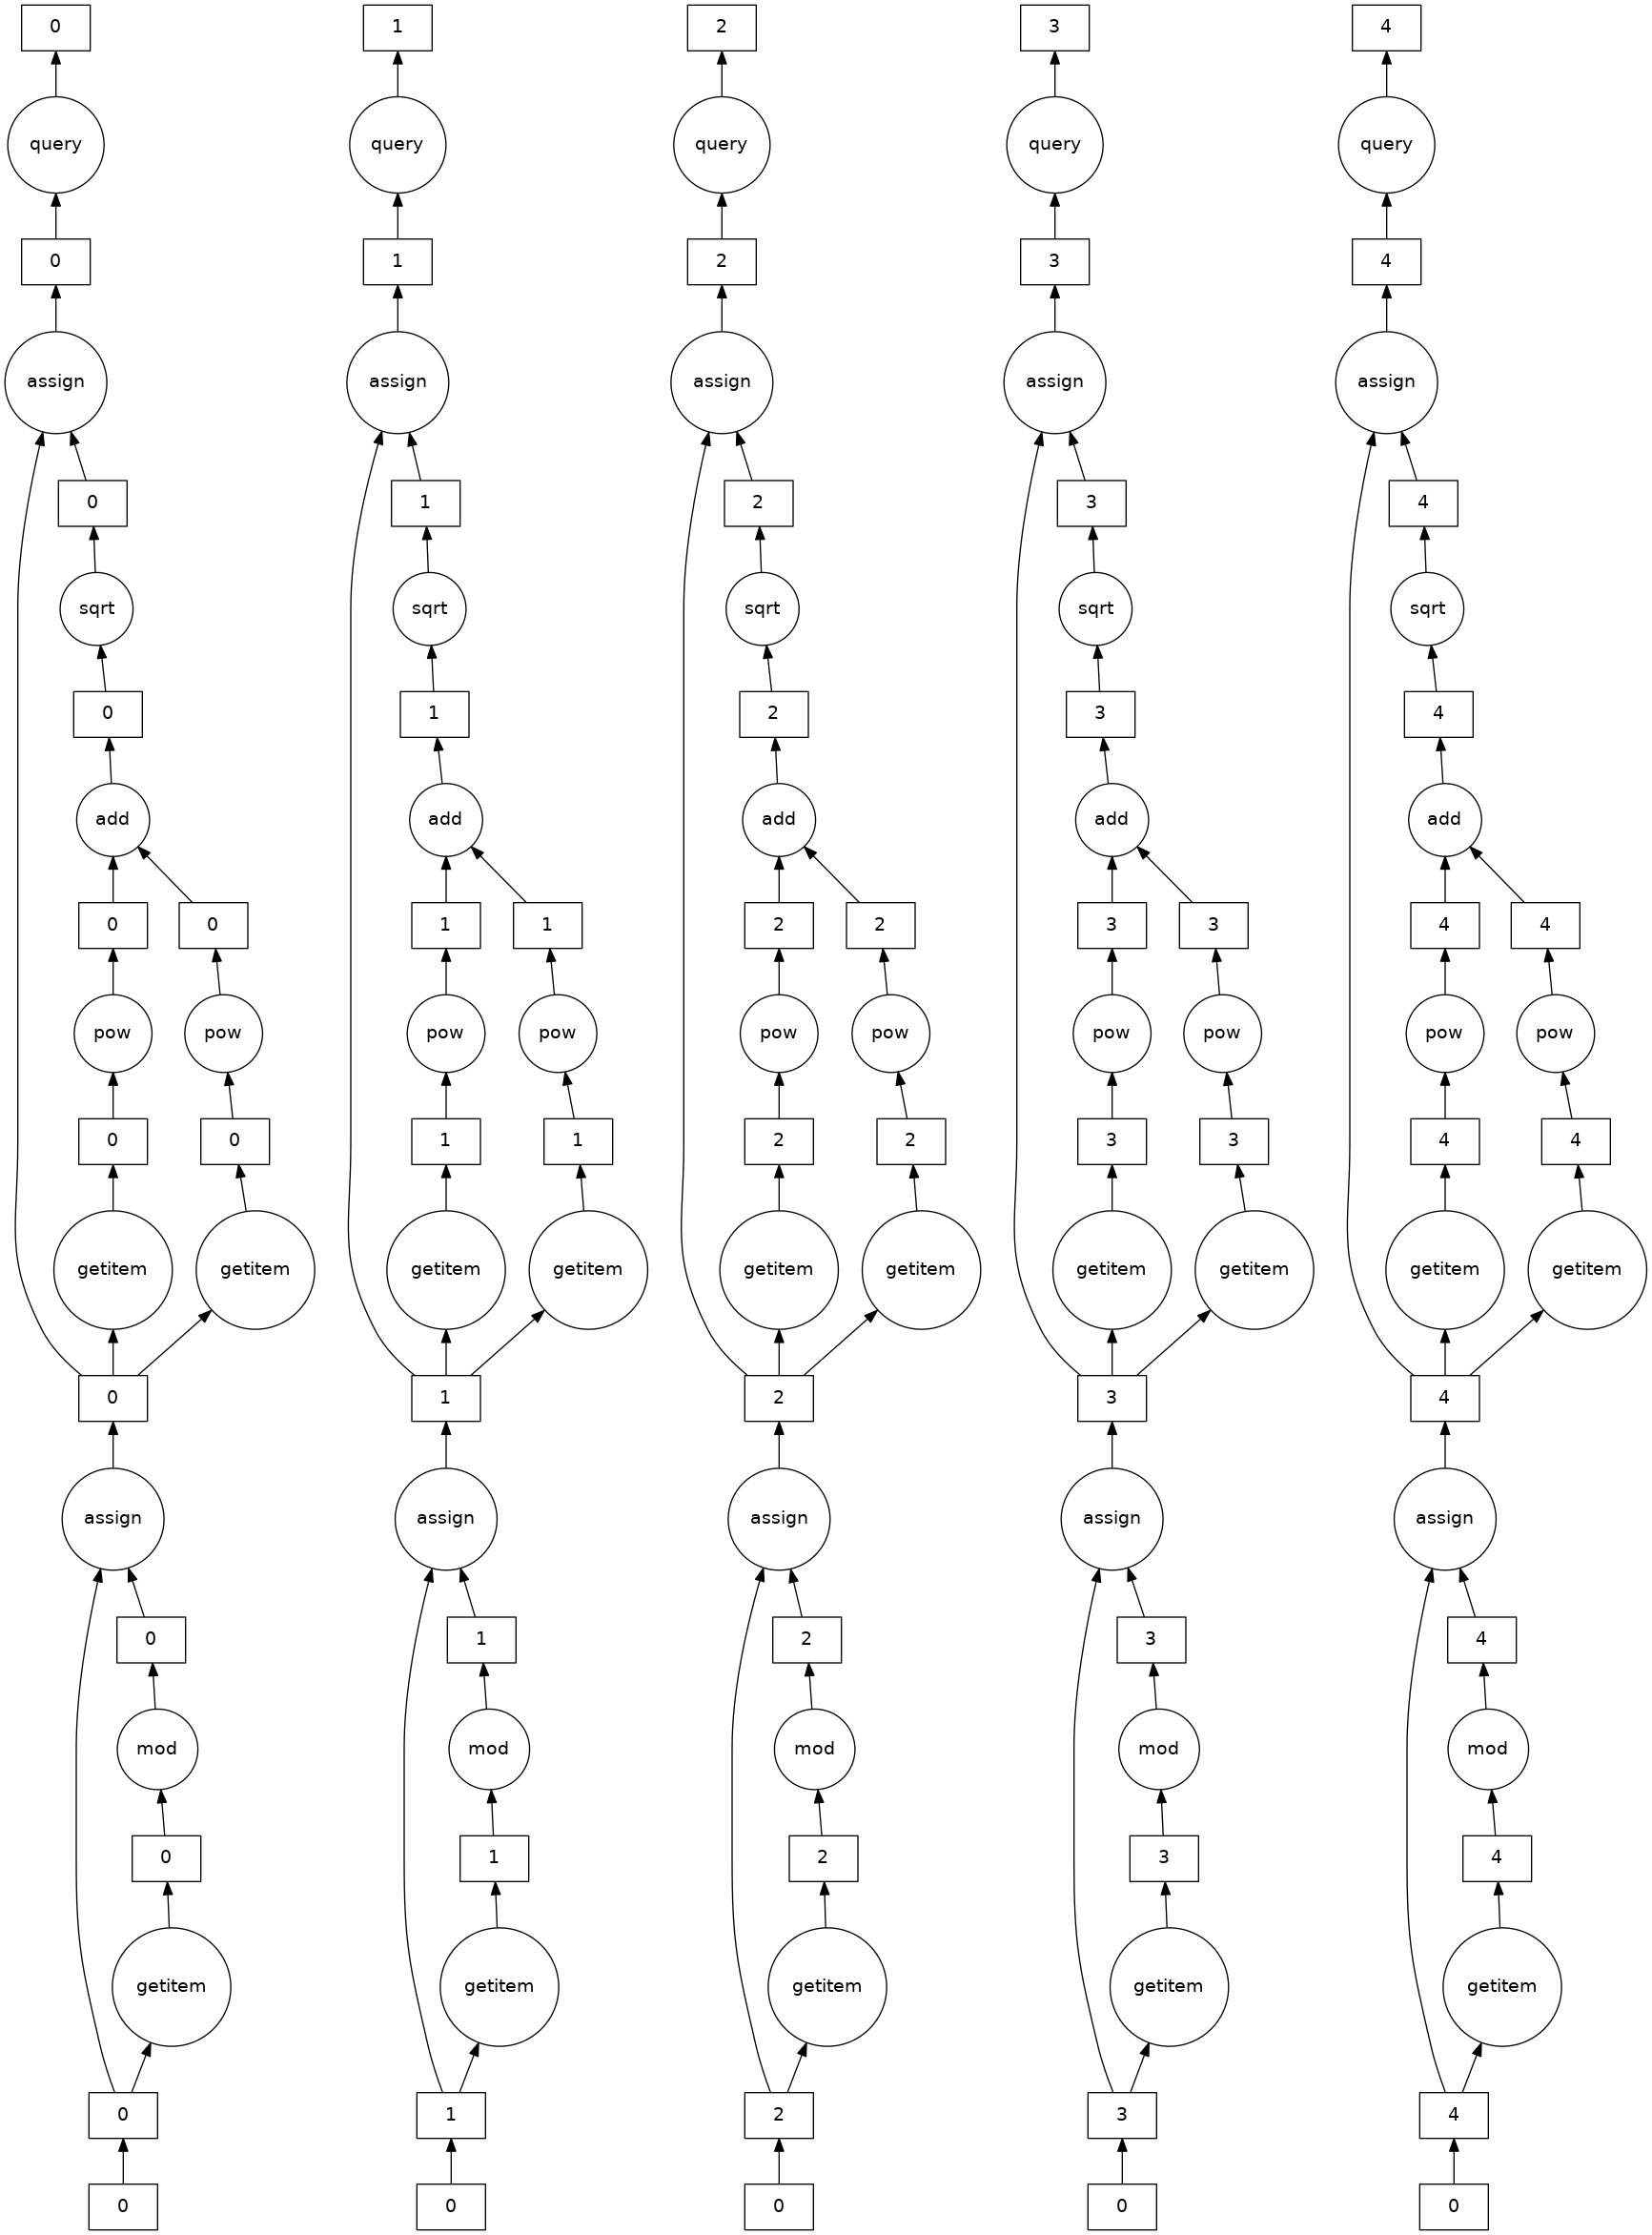

In [20]:

matchcats = [
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5544/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5545/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5546/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5547/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder4/Npix396/catalog.parquet',  '/epyc/projects3/sam_hipscat/output/gaia_real/Norder3/Npix99/catalog.parquet']
]


with open('/epyc/projects3/sam_hipscat/output/sdss_real/sdss_real_meta.json') as f:
    c1_md = json.load(f)
with open('/epyc/projects3/sam_hipscat/output/gaia_real/gaia_real_meta.json') as f:
    c2_md = json.load(f)

c1_cols = ['RA', 'DEC', 'ID',]
c2_cols = ['ra', 'dec', 'pmra', 'pmdec', 'source_id']

futures = client.map(
    xmatcher2,
    matchcats,
    c1_md=c1_md, 
    c2_md=c2_md,
    c1_cols=c1_cols,
    c2_cols=c2_cols
)

result = dd.concat(
    [x.result() for x in futures]
).assign(
    probRRLyra=lambda x: x.ID % 5, 
    pm=lambda x:np.sqrt(x.pmra**2 + x.pmdec**2)
).query(
    'probRRLyra > 3 and pm > 10.0'
)
result.visualize()

#client.restart()

In [25]:
client.close()

In [6]:
n_neighbors = 1
dthresh = 0.01


def gc_dist(lon1, lat1, lon2, lat2):

    lon1 = np.radians(lon1); lat1 = np.radians(lat1)
    lon2 = np.radians(lon2); lat2 = np.radians(lat2)

    return np.degrees(2*np.arcsin(np.sqrt( (np.sin((lat1-lat2)*0.5))**2 + np.cos(lat1)*np.cos(lat2)*(np.sin((lon1-lon2)*0.5))**2 )))


def frame_cull(df, df_md, order, pix, cols=[], tocull=True):
    if tocull:
        df['hips_pix'] = hp.ang2pix(2**order, 
            df[df_md['ra_kw']].values, 
            df[df_md['dec_kw']].values, 
            lonlat=True, nest=True
        )
        df = df.loc[df['hips_pix'].isin([pix])]
        df['hips_k'] = order
    #user specifies which columns to return
    if len(cols):
        #ensure user doesn't cull the ra,dec,and id columns
        expected_cols = [
            df_md['ra_kw'],
            df_md['dec_kw'],
            df_md['id_kw']
        ]
        for ec in expected_cols:
            if ec not in cols:
                cols.append(ec)
        df = df[cols]

    return df


def frame_gnomonic(df, df_md, clon, clat):

    phi  = np.radians(df[df_md['dec_kw']].values)
    l    = np.radians(df[df_md['ra_kw']].values)
    phi1 = np.radians(clat)
    l0   = np.radians(clon)

    cosc = np.sin(phi1)*np.sin(phi) + np.cos(phi1)*np.cos(phi)*np.cos(l-l0)
    x = np.cos(phi)*np.sin(l-l0) / cosc
    y = (np.cos(phi1)*np.sin(phi) - np.sin(phi1)*np.cos(phi)*np.cos(l-l0)) / cosc

    ret = np.column_stack((np.degrees(x), np.degrees(y)))
    del phi, l, phi1, l0, cosc, x, y
    return ret


def xmatcher3(c1, c2, c1_md, c2_md, order, pix, tocull1, tocull2, c1_cols=[], c2_cols=[], n_neighbors=1, dthresh=0.01):
    pass


def which_cull_and_pixorder(c1, c2):
    
    c1_order = int(c1.split('Norder')[1].split('/')[0])
    c1_pix = int(c1.split('Npix')[1].split('/')[0])
    c2_order = int(c2.split('Norder')[1].split('/')[0])
    c2_pix = int(c2.split('Npix')[1].split('/')[0])    

    tocull1 = False
    tocull2 = False

    if c2_order > c1_order:
        order, pix = c2_order, c2_pix
        tocull1=True
    else:
        order, pix = c1_order, c1_pix
        tocull2=True

    return order, pix, tocull1, tocull2


def establish_pd_meta(c1_cols, c2_cols):
    colnames = []
    colnames.extend(c1_cols)
    colnames.extend(c2_cols)
    colnames.extend(['hips_k', 'hips_pix', '_DIST'])
    return colnames


def xmatch_from_daskdf(df, c1_md, c2_md, c1_cols, c2_cols,n_neighbors=1, dthresh=0.01):
    

    order = df.Order
    pix = df.Pix
    tocull1 = df.ToCull1
    tocull2 = df.ToCull2

    vals = zip(
        df['C1'], 
        df['C2'],
        df['Order'],
        df['Pix'],
        df['ToCull1'],
        df['ToCull2']
    )

    #c1 = match_cats[0]
    #c2 = match_cats[1]
    colnames = establish_pd_meta(c1_cols, c2_cols)
    retdfs = []
    for c1, c2, order, pix, tocull1, tocull2 in vals:

        try:
            c1_df = pd.read_parquet(c1, engine='pyarrow',  columns=c1_cols)
            c2_df = pd.read_parquet(c2, engine='pyarrow', columns=c2_cols)


            (clon, clat) = hp.pix2ang(hp.order2nside(order), pix, nest=True, lonlat=True)

            c1_df = frame_cull(
                df=c1_df, df_md=c1_md,
                order=order, pix=pix,
                cols=c1_cols,
                tocull=tocull1
            )

            c2_df = frame_cull(
                df=c2_df, df_md=c2_md,
                order=order, pix=pix,
                cols=c2_cols,
                tocull=tocull2
            )

            #ret = 0
            if len(c1_df) and len(c2_df):

                xy1 = frame_gnomonic(c1_df, c1_md, clon, clat)
                xy2 = frame_gnomonic(c2_df, c2_md, clon, clat)

                tree = KDTree(xy2, leaf_size=2)
                dists, inds = tree.query(xy1, k=n_neighbors)

                outIdx = np.arange(len(c1_df)*n_neighbors)
                leftIdx = outIdx // n_neighbors
                rightIdx = inds.ravel()
                out = pd.concat(
                    [
                        c1_df.iloc[leftIdx].reset_index(drop=True),   # select the rows of the left table
                        c2_df.iloc[rightIdx].reset_index(drop=True)  # select the rows of the right table
                    ], axis=1)  # concat the two tables "horizontally" (i.e., join columns, not append rows)

                out['hips_k'] = order
                out['hips_pix'] = pix
                out["_DIST"] = gc_dist(
                    out[c1_md['ra_kw']], out[c1_md['dec_kw']],
                    out[c2_md['ra_kw']], out[c2_md['dec_kw']]
                )

                out = out.loc[out['_DIST'] < dthresh]
                
                retdfs.append(out)
                del out, dists, inds, outIdx, leftIdx, rightIdx, xy1, xy2

            else:
                retdfs.append(pd.DataFrame({}, columns=colnames))
            del c1_df, c2_df

        except:
            retdfs.append(pd.DataFrame({}, columns=colnames))

    return pd.concat(retdfs)


#main test

matchcats = [
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5544/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5545/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5546/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder5/Npix5547/catalog.parquet', '/epyc/projects3/sam_hipscat/output/gaia_real/Norder4/Npix1386/catalog.parquet'], 
    ['/epyc/projects3/sam_hipscat/output/sdss_test/Norder4/Npix396/catalog.parquet',  '/epyc/projects3/sam_hipscat/output/gaia_real/Norder3/Npix99/catalog.parquet']
]

c1, c2 = [], []
o, p, = [], []
tc1, tc2 = [], []
for m in matchcats:
    c1.append(m[0])
    c2.append(m[1])

    order, pix, tocull1, tocull2 = which_cull_and_pixorder(m[0], m[1])

    o.append(order)
    p.append(pix)
    tc1.append(tocull1)
    tc2.append(tocull2)

data = {
        'C1': c1,
        'C2': c2,
        'Order' : o,
        'Pix' : p,
        'ToCull1': tc1,
        'ToCull2': tc2
}

matchcats_df = dd.from_pandas(
    pd.DataFrame(
        data, 
        columns = list(data.keys())
    ).reset_index(drop=True), 
    npartitions=len(c1)
)

print(matchcats_df.compute())

with open('/epyc/projects3/sam_hipscat/output/sdss_real/sdss_real_meta.json') as f:
    c1_md = json.load(f)
with open('/epyc/projects3/sam_hipscat/output/gaia_real/gaia_real_meta.json') as f:
    c2_md = json.load(f)

c1_cols = {'RA':'f8', 'DEC':'f8', 'ID':'i8'}
c2_cols = {'ra':'f8', 'dec':'f8', 'pmra':'f8', 'pmdec':'f8', 'source_id':'i8'}

meat = {}
meat.update(c1_cols)
meat.update(c2_cols)
meat.update({
    'hips_k':'i8', 
    'hips_pix':'i8',
    '_DIST':'f8'
})


result = matchcats_df.map_partitions(
    xmatch_from_daskdf,
    c1_md, c2_md,
    c1_cols.keys(), c2_cols.keys(),
    meta=meat
).assign(
    filter1=lambda x: x.ID % 5, 
    filter2=lambda x:np.sqrt(x.pmra**2 + x.pmdec**2)
).query(
    'filter1 > 3 and filter2 > 10.0'
).compute()

result.head()


                                                  C1  \
0  /epyc/projects3/sam_hipscat/output/sdss_test/N...   
1  /epyc/projects3/sam_hipscat/output/sdss_test/N...   
2  /epyc/projects3/sam_hipscat/output/sdss_test/N...   
3  /epyc/projects3/sam_hipscat/output/sdss_test/N...   
4  /epyc/projects3/sam_hipscat/output/sdss_test/N...   

                                                  C2  Order   Pix  ToCull1  \
0  /epyc/projects3/sam_hipscat/output/gaia_real/N...      5  5544    False   
1  /epyc/projects3/sam_hipscat/output/gaia_real/N...      5  5545    False   
2  /epyc/projects3/sam_hipscat/output/gaia_real/N...      5  5546    False   
3  /epyc/projects3/sam_hipscat/output/gaia_real/N...      5  5547    False   
4  /epyc/projects3/sam_hipscat/output/gaia_real/N...      4   396    False   

   ToCull2  
0     True  
1     True  
2     True  
3     True  
4     True  


/astro/users/sdwyatt/anaconda3/envs/hipsenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/astro/users/sdwyatt/anaconda3/envs/hipsenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,RA,DEC,ID,ra,dec,pmra,pmdec,source_id,hips_k,hips_pix,_DIST,filter1,filter2
396,91.514598,-1.154214,1809,91.514640,-1.154294,8.938547,-17.038108,3121370265507122432,5,5544,0.000089,4,19.240445
616,91.584551,-1.084463,189,91.584560,-1.084544,0.135153,-15.280107,3121372331388459904,5,5544,0.000081,4,15.280705
628,91.592872,-1.259904,209,91.596943,-1.260000,-13.029054,-21.594876,3121364909685009280,5,5544,0.004071,4,25.220922
800,91.655635,-1.214880,539,91.655760,-1.214989,23.939343,-20.122452,3121366657735242624,5,5544,0.000165,4,31.273075
806,91.655226,-1.263254,549,91.658757,-1.262351,-7.222670,-21.354862,3121364703526566144,5,5544,0.003644,4,22.543227
